In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
original_data = pd.read_csv("OnlineNewsPopularity.csv")
col_names = original_data.columns.tolist()
for index,value in enumerate(col_names):
    col_names[index]= value.replace(" ","")
    
original_data.columns=col_names 

In [3]:
drop_list = ['url',
             'timedelta',
             'n_non_stop_words',
             'n_non_stop_unique_tokens',
             'weekday_is_monday',
             'weekday_is_tuesday',
             'weekday_is_wednesday', 
             'weekday_is_thursday', 
             'weekday_is_friday',
             'weekday_is_saturday', 
             'weekday_is_sunday',
             'kw_max_max',
             'kw_max_min',
             'kw_max_avg',
             'self_reference_min_shares',
             'self_reference_max_shares']
extracted_data = original_data.drop(labels=drop_list, axis = 1)

# 1st quartile (25%)
Q1 = np.percentile(extracted_data["shares"], 25)
# 3rd quartile (75%)
Q3 = np.percentile(extracted_data["shares"], 75)
# Interquartile range (IQR)
IQR = Q3 - Q1

# outlier step
outlier_step = 3 * IQR
upper_boundary = Q3 + outlier_step
extracted_data = extracted_data[extracted_data["shares"] <= upper_boundary]
extracted_data.reset_index(drop=True)
extracted_data.loc[extracted_data["n_unique_tokens"]==701,"n_unique_tokens"] = 0.701


# 4.1  LinearRegression

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
training_set = extracted_data.drop(labels=["shares"],axis=1)
target_set = extracted_data["shares"]

scaler_list = training_set.columns.tolist()

training_set = scaler.fit_transform(training_set)
training_set = pd.DataFrame(training_set,columns=scaler_list)


X_train,X_test,y_train,y_test = train_test_split(training_set,target_set,test_size=0.2,random_state=42)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
rmse = mean_squared_error(y_pred, y_test,squared=False)
print( f"the root mean squared error is: {rmse}")

the root mean squared error is: 348164326599.41876


removing the outliers from Features

In [6]:
training_set_new = extracted_data.drop(labels=["shares"],axis=1)


training_set_new = training_set_new.mask((training_set_new - training_set_new.mean()).abs() > 2 * training_set_new.std())
training_set_new = training_set_new.fillna(training_set_new.mean())
training_set_new = scaler.fit_transform(training_set_new)
training_set_new = pd.DataFrame(training_set_new,columns=scaler_list)

X_train_new,X_test_new,y_train_new,y_test_new = train_test_split(training_set_new,target_set,test_size=0.2,random_state=42)

In [7]:
lin_reg.fit(X_train_new, y_train_new)

y_pred_linear = lin_reg.predict(X_test_new)
new_rmse = mean_squared_error(y_pred_linear, y_test_new,squared=False)
print( f"the root mean squared error after removing the outliers is: {new_rmse}")

the root mean squared error after removing the outliers is: 1502.0854100358795


Polynomial Regression

In [8]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2)

X_train_poly = poly_features.fit_transform(X_train_new)
X_test_poly = poly_features.fit_transform(X_test_new)

lin_reg.fit(X_train_poly, y_train_new)
y_pred_poly = lin_reg.predict(X_test_poly)
rmse = mean_squared_error(y_pred_poly, y_test_new,squared=False)
print( f"the root mean squared error with polynomial is: {rmse}")

the root mean squared error with polynomial is: 1507.1793228532115


Regularized Linear Models

In [9]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X_train_new, y_train_new)

y_pred_ridge = ridge_reg.predict(X_test_new)
rmse = mean_squared_error(y_pred_ridge, y_test_new,squared=False)
print( f"the root mean squared error with ridge regressor is: {rmse}")

the root mean squared error with ridge regressor is: 1502.1080608475513


In [10]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1, random_state=42)
lasso_reg.fit(X_train_new, y_train_new)

y_pred_lasso = lasso_reg.predict(X_test_new)
rmse = mean_squared_error(y_pred_lasso, y_test_new,squared=False)
print( f"the root mean squared error with lasso regressor is: {rmse}")

the root mean squared error with lasso regressor is: 1502.1833956259707


# 4.2 Influence of Dataset size on Training & Test Error

In [11]:
def dataset_size_curve(model, X, y):
    X_train, X_test, y_train, y_vest = train_test_split(X, y, test_size=0.2, random_state=42)
    train_errors, test_errors = [], []
    m = 100
    while m < (len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))
        m += 1000
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train error")
    plt.plot(np.sqrt(test_errors), "b-", linewidth=3, label="test error")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)              

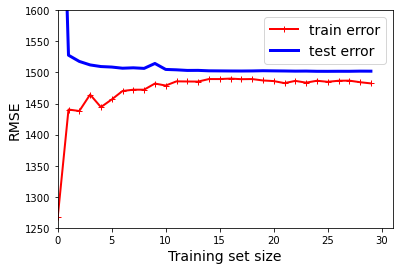

In [12]:
dataset_size_curve(lin_reg, training_set_new, target_set)
plt.axis([0, 31, 1250, 1600])           
plt.show()      

# 4.3  Hyperparameter Optimization

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': list(range(100,121,10)), 'min_samples_leaf': list(range(40,47,3)), 'max_depth': [6,8]}
grid_search_cv = GridSearchCV(RandomForestRegressor(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train_new[:10000], y_train_new[:10000])
grid_search_cv.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


RandomForestRegressor(max_depth=8, min_samples_leaf=40, n_estimators=120,
                      random_state=42)

In [14]:
y_pred_rnd = grid_search_cv.predict(X_test_new)
rmse = mean_squared_error(y_pred_rnd, y_test_new,squared=False)
print(f"the root mean squared error with Regressor hyperparameter turning is {rmse}")

the root mean squared error with Regressor hyperparameter turning is 1489.9410884423066


In [15]:
rnd_ori_para = RandomForestRegressor(random_state=42)
rnd_clf_para = RandomForestRegressor(max_depth=8, min_samples_leaf=50, n_estimators=90, random_state=42)

rnd_ori_para.fit(X_train_new[:10000], y_train_new[:10000])
rnd_clf_para.fit(X_train_new[:10000], y_train_new[:10000])

y_pred_ori = rnd_ori_para.predict(X_test_new)
y_pred_clf = rnd_clf_para.predict(X_test_new)

regressor_list = ["with no hyperparameter turning", "with Classifier hyperparameter turning"]
y_pred_list = [y_pred_ori, y_pred_clf]

for regressor, y_pred in zip(regressor_list,y_pred_list):
    rmse = mean_squared_error(y_pred, y_test,squared=False)
    
    print(f"the root mean squared error {regressor} is {rmse}")

the root mean squared error with no hyperparameter turning is 1513.5017377439776
the root mean squared error with Classifier hyperparameter turning is 1490.4769664930764


# 4.4  Stacking

In [16]:
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold

In [17]:
# 5 regressors are used for the first layer

models=[RandomForestRegressor(max_depth=8, min_samples_leaf=46, n_estimators=110,random_state=42),
        AdaBoostRegressor(learning_rate=0.5, n_estimators=80, random_state=42),
        SVR(),
        GradientBoostingRegressor(n_estimators=110,random_state=42),
        Ridge(alpha=1, solver="cholesky", random_state=42)]

In [18]:
# the dataset is transformed to ndArray matrix, since in Dataframe and Series the index will be shuffled in KFold and cause unmachting problem

x_train = X_train_new.values
y_train = y_train_new.values
x_test = X_test_new.values
y_test = y_test_new.values

kf=KFold(n_splits=5)
n_train=x_train.shape[0]
n_test=x_test.shape[0]           
print(n_train)
print(n_test)

29503
7376


Define a function to return the predicted value as feature.The first return value is the feature of the training set for the second layer model; the second return value is the prediction of the test set by the first layer model, which will be used as the X_test of the training set for the second layer model.

In [19]:
def get_oof(model,x_train,y_train,x_test):
    oof_train=np.zeros((n_train,))     # create a 29503 * 1 zero matrix  
    oof_test=np.zeros((n_test,))       #create a 7376 * 1 zero matrix  
    oof_test_skf=np.zeros((5,n_test))  # 5 * 7376 zero matrix
    for i,(train_index,test_index) in enumerate(kf.split(x_train)):
        kf_x_train=x_train[train_index]            # 23602 instances from training set in every fold
        kf_y_train=y_train[train_index]            # 23602 target values from training set in every fold
        kf_x_test=x_train[test_index]              #  5901 instances from test set in every fold
        model=model.fit(kf_x_train,kf_y_train)
        oof_train[test_index]=model.predict(kf_x_test)        #every fold can give us 5901 prediction values from Kfold，then we can get 29503 predictions for training set
        oof_test_skf[i,:]=model.predict(x_test)               #every fold can also give 7376 prediction values from test set.
    oof_test[:]=oof_test_skf.mean(axis=0)            #calculate the mean value of 5 times prediction from the test se 
    return oof_train,oof_test              

In [20]:
number_models=len(models)
xtrain_new=np.zeros((n_train,number_models))
xtest_new=np.zeros((n_test,number_models))

# the output as meta feature will be trained in second layer 
for i,regressor in enumerate(models):
    xtrain_new[:,i],xtest_new[:,i]=get_oof(regressor,x_train,y_train,x_test) 

In [21]:
pd.DataFrame(xtrain_new)  # new features for training data

,0,1,2,3,4
0,2075.045395,2964.841065,1398.344827,2039.361555,1956.637421
1,2392.099039,2893.142397,1353.234486,2367.791394,1934.902312
2,2375.726598,3017.861569,1496.913724,2620.756481,2357.003408
3,1467.677248,2220.532612,1181.521401,1491.529684,1903.669717
4,1949.033519,2400.175031,1204.608386,1713.527779,1824.986944
...,...,...,...,...,...
29498,1289.230163,1991.285965,1178.917172,1283.131391,1222.833398
29499,2007.638607,2876.992553,1325.959616,2008.751715,2183.280494
29500,1364.185118,2148.467800,1147.881760,1383.008785,1147.514338
29501,1713.124251,2284.655204,1263.797978,1751.759765,1155.093199


In [22]:
pd.DataFrame(xtest_new)  # new features for test data

,0,1,2,3,4
0,1469.153575,2237.965878,1147.596600,1437.517144,1330.530096
1,1916.271656,2444.779991,1363.144758,1749.671331,1623.095694
2,1883.679348,2485.462487,1275.299074,1769.756390,1459.980361
3,1261.308747,2287.177998,1318.664726,1104.563391,1564.743912
4,2015.507177,2672.846791,1412.569964,2019.807894,1969.333572
...,...,...,...,...,...
7371,2344.282609,2959.448837,1221.421242,2341.591258,1885.883684
7372,2435.961849,3044.231779,1459.236498,2317.983593,2163.053391
7373,1997.945586,2538.780874,1482.020072,2055.870060,2166.842416
7374,2840.548163,2998.807172,1399.889571,2639.089500,2470.309060


In [23]:
reg = LinearRegression() # use a simply regressor for second layer
reg=reg.fit(xtrain_new,y_train) # the predicted values as new feature in second layer
y_pred = reg.predict(xtest_new) # the predicted values from test set are averaged and used as new X_test
rmse = mean_squared_error(y_pred, y_test,squared=False)
print( f"the root mean squared error with stacking is: {rmse}")

the root mean squared error with stacking is: 1477.241773650398
